<a href="https://colab.research.google.com/github/omkar-salunke/Modelling-Driving-Behavior-using-HMM/blob/master/Speech_recognition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/omkar-salunke/Modelling-Driving-Behavior-using-HMM.git

fatal: destination path 'Modelling-Driving-Behavior-using-HMM' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [3]:
!ls Modelling-Driving-Behavior-using-HMM/Audio

apple  book  cat  dog  eye  fast  god  human


In [4]:
fpaths = []
labels = []
spoken = []
for f in os.listdir('Modelling-Driving-Behavior-using-HMM/Audio'):
    for w in os.listdir('Modelling-Driving-Behavior-using-HMM/Audio/' + f):
        fpaths.append('Modelling-Driving-Behavior-using-HMM/Audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)




Words spoken: ['fast', 'cat', 'god', 'human', 'apple', 'dog', 'eye', 'book']


In [5]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000
from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    #print d.shape
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 120
Labels and label indices [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]


In [6]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):   
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

(119, 32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  


Text(0.5, 1.0, 'PSD of fast example')

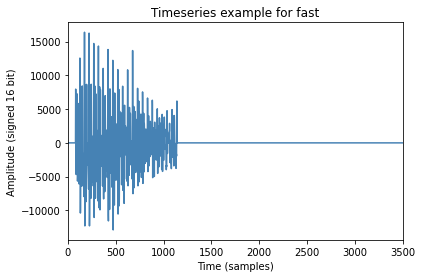

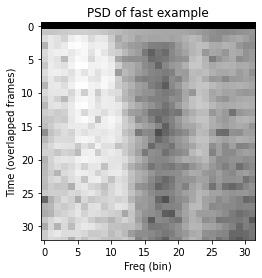

In [7]:
import matplotlib.pyplot as plt
plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

In [8]:
from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  


Text(0, 0.5, 'Amplitude')

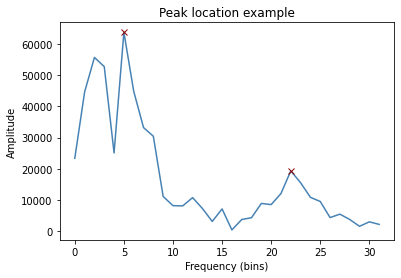

In [9]:
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=8)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

In [10]:
#This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
#MFCC (or deep NN/automatic feature extraction) could be interesting
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  


Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100
Processed obs 110


In [11]:
print(all_obs.shape)
print(data.shape)

(120, 6, 119)
(120, 3841)


In [12]:
import scipy.stats as st
from scipy.stats import multivariate_normal
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=8):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 221.3941427176605
M2: 165.68854588913212
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.20045732115577
M2: 60.30510397138957
Prediction for test set 2
Model 2


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(test_size=0.10, random_state=0)

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)
for train_index, test_index in sss.split(all_obs, all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
dictionary = ['eye', 'apple', 'book', 'human', 'god', 'fast', 'dog', 'cat']
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Size of training matrix: (102, 6, 119)
Size of testing matrix: (18, 6, 119)
Test accuracy: 44.44 percent


In [14]:
'''import numpy as np
from sys import byteorder
from array import array
from struct import pack

import pyaudio
import wave
import time
%matplotlib inline
THRESHOLD = 32000
CHUNK_SIZE = 64
FORMAT = pyaudio.paInt16
RATE = 8000

def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

def normalize(snd_data):
    "Average the volume out"
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)

    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

def trim(snd_data):
    "Trim the blank spots at the start and end"
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)

            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

def add_silence(snd_data, seconds):
    "Add silence to the start and end of 'snd_data' of length 'seconds' (float)"
    r = array('h', [0 for i in xrange(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in xrange(int(seconds*RATE))])
    return r

def record():
    """
    Record a word or words from the microphone and 
    return the data as an array of signed shorts.

    Normalizes the audio, trims silence from the 
    start and end, and pads with 0.5 seconds of 
    blank sound to make sure VLC et al can play 
    it without getting chopped off.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 30:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.01)
    return sample_width, r

def record_to_file(path):
    "Records from the microphone and outputs the resulting data to 'path'"
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

if __name__ == '__main__':
    #print("start")
    
    s=["apple","banana","cat","dog","eye","fast","gate","human","ice","johnny"]
    for i,name in enumerate(s):
        pathstart= "/home/ashutosh/Downloads/hmm-speech-recognition-0.1/hmm-speech-recognition-0.1/Audio/" + name
        for i in range(15):
            print("Please speak a word into the microphone for " + name)
            record_to_file(pathstart+"/"+ name + str(i))
            time.sleep(0.5)
        time.sleep(5)
        print("Done")
    print("Please speak a word into the microphone for ")
    record_to_file('/home/ashutosh/Downloads/Speech_Recognition/Audio/testaudio.wav')
    print("Done")'''

new_data = np.zeros(5000)
maxsize = 3841
_, new_d = wavfile.read("Modelling-Driving-Behavior-using-HMM/Audio/human/human0.wav")
new_data[:new_d.shape[0]] = new_d
new_data = new_data[:maxsize]
#from array import array
observation = []

new_d = np.abs(stft(new_data))
n_dim = 6
new_obs = np.zeros((n_dim, new_d.shape[0]))
for r in range(new_d.shape[0]):
    _, t = peakfind(new_d[r, :], n_peaks=n_dim)
    new_obs[:, r] = t.copy()
observation.append(new_obs)
observation = np.atleast_3d(observation)
observation /= observation.sum(axis=1)
#observation = array("i", observation)
ps_test = [m.transform(observation) for m in ms]
res_test = np.vstack(ps_test)
test_predicted_label = np.argmax(res_test, axis=0)
word_spoken = dictionary[test_predicted_label.item()]
print(word_spoken)


fast


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.hanning is deprecated and will be removed in SciPy 2.0.0, use numpy.hanning instead
  
